# Sivers Function Distributions

In [78]:
import tensorflow as tf
import pandas as pd
import numpy as np
import lhapdf
import matplotlib.pyplot as plt

In [19]:
import NewFunctions

In [20]:
class A0(tf.keras.layers.Layer):
    def __init__(self, kperp2avg=.57, pperp2avg=.12, **kwargs):
        super(A0, self).__init__(name='a0')
        self.m1 = tf.Variable(1., name='m1')
        self.kperp2avg = kperp2avg
        self.pperp2avg = pperp2avg
        self.e = tf.constant(1.)
        
    def get_config(self):
        config = super().get_config().copy()
        
        config.update({
            'kperp2avg': self.kperp2avg,
            'pperp2avg': self.pperp2avg
        })
        
        return config
        
    def call(self, inputs):
        z = inputs[:, 0]
        pht = inputs[:, 1]
        ks2avg = (self.kperp2avg*self.m1**2)/(self.m1**2 + self.kperp2avg) #correct 
        topfirst = (z**2 * self.kperp2avg + self.pperp2avg) * ks2avg**2 #correct
        bottomfirst = (z**2 * ks2avg + self.pperp2avg)**2 * self.kperp2avg #correct
        exptop = pht**2 * z**2 * (ks2avg - self.kperp2avg) #correct
        expbottom = (z**2 * ks2avg + self.pperp2avg) * (z**2 * self.kperp2avg + self.pperp2avg) #correct
        last = tf.sqrt(2*self.e) * z * pht / self.m1 #correct
        
        return (topfirst/bottomfirst) * tf.exp(-exptop/expbottom) * last

In [21]:
class Quotient(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Quotient, self).__init__()
    
    def call(self, inputs):
        if len(inputs) != 2 or inputs[0].shape[1] != 1:
            raise Exception('must be two tensors of shape (?, 1)')
        return inputs[0]/inputs[1]

In [22]:
def xsivdist(model, x, QQ, kperp2avg, flavor, kperp):
    refDict = {-3: 'nnsbar',
               -2: 'nnubar',
               -1: 'nndbar',
               1: 'nnd',
               2: 'nnu',
               3: 'nns'}
    nnqval = nnq(model, np.array([x]), refDict[flavor])
    hval = h(model, kperp)
    fqpval = fqp([x], [QQ], kperp2avg, kperp, flavor)
    
    return ((2*nnqval*hval*fqpval)[0, :])*x

In [23]:
def xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, flavor, kperp):
    results = []
    for i in range(numReplicas):
        t = tf.keras.models.load_model('Models/rep' + str(i) + '.h5', 
                                         custom_objects={'A0': A0, 'Quotient': Quotient})
        results.append(list(xsivdist(t, x, QQ, kperp2avg, flavor, kperp)))
    return np.array(results)

In [24]:
def nnq(model, x, hadronstr):
    if not hadronstr in ['nnu', 'nnd', 'nns', 'nnubar', 'nndbar', 'nnsbar']:
        raise Exception('hadronstr must be one of nnu, nnd, nns, nnubar, nndbar, nnsbar')
    lilmod = tf.keras.backend.function(model.get_layer('x').input,
                                       model.get_layer(hadronstr).output)
    return lilmod(x)

In [26]:
def h(model, kperp):
    m1 = model.get_layer('a0').m1.numpy()
    e = model.get_layer('a0').e.numpy()
    return np.sqrt(2*e) * (kperp/m1) * np.exp(-kperp**2/m1**2)

In [27]:
def fqp(x, QQ, kperp2avg, kperp, flavor):
    '''
    x and QQ must be iterables of some kind
    '''
    had = NewFunctions.Hadron()
    fq = had.pdf(flavor, x, QQ)
    return fq*(1/(np.pi*kperp2avg))*np.exp(-kperp**2/kperp2avg)

In [32]:
def plotSivDistBands(numReplicas, x, QQ, kperp2avg, flavor, kperp, title, pdfname, numSigma=2):
    #datann = DataANN()
    #X, y, err = datann.makeData(df, [hadron], [dependence])

    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, 2, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)

    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='b', alpha=0.3, label='$u$')
    plt.plot(kperp, yhat, 'b')
    
    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, 1, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='r', alpha=0.3, label='$d$')
    plt.plot(kperp, yhat, 'r')
    
    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, 3, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='g', alpha=0.3, label='$s$')
    plt.plot(kperp, yhat, 'g')
    
    plt.legend()
    plt.title(title)
    plt.xlabel('$k_{\perp}$')
    plt.ylabel('$x\Delta^Nf(x, k_{\perp})$')
    plt.savefig(pdfname, format='pdf', bbox_inches='tight')

In [33]:
def plotSivDistBandsSea(numReplicas, x, QQ, kperp2avg, flavor, kperp, title, pdfname, numSigma=2):
    #datann = DataANN()
    #X, y, err = datann.makeData(df, [hadron], [dependence])

    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, -2, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)

    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='b', alpha=0.3, label='$u_{sea}$')
    plt.plot(kperp, yhat, 'b')
    
    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, -1, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='r', alpha=0.3, label='$d_{sea}$')
    plt.plot(kperp, yhat, 'r')
    
    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, -3, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='g', alpha=0.3, label='$s_{sea}$')
    plt.plot(kperp, yhat, 'g')
    
    plt.legend()
    plt.title(title)
    plt.xlabel('$k_{\perp}$')
    plt.ylabel('$x\Delta^Nf(x, k_{\perp})$')
    plt.savefig(pdfname, format='pdf', bbox_inches='tight')

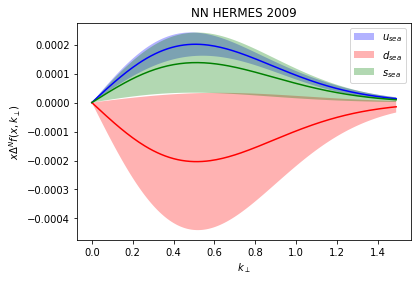

In [30]:
plotSivDistBandsSea(10, .1, 2.4, .57, -2, np.array(list(range(150)))/100, 'NN HERMES 2009', 'Plot2.pdf')

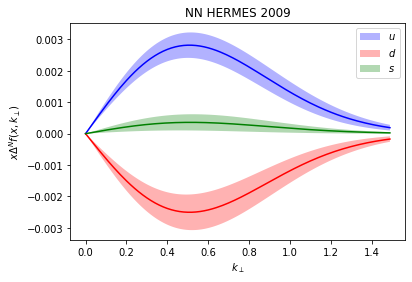

In [34]:
plotSivDistBands(10, .1, 2.4, .57, -2, np.array(list(range(150)))/100, 'NN HERMES 2009', 'Plot6.pdf')

## Non NN

In [59]:
def xsivdistNonNN(params, x, QQ, kperp2avg, flavor, kperp):
    refDict = {-3: 'nnsbar',
               -2: 'nnubar',
               -1: 'nndbar',
               1: 'nnd',
               2: 'nnu',
               3: 'nns'}
    nnqval = nnqNonNN(params, np.array([x]), refDict[flavor])
    hval = hNonNN(params, kperp)
    fqpval = fqp([x], [QQ], kperp2avg, kperp, flavor)
    
    return ((2*nnqval*hval*fqpval))*x

def xsivdistFromReplicasNonNN(params, paramssigmas, x, QQ, kperp2avg, flavor, kperp):
    results = []
    for i in range(100):
        params = [np.random.normal(p, s) for p, s in zip(params, paramssigmas)]
        results.append(list(xsivdistNonNN(params, x, QQ, kperp2avg, flavor, kperp)))
    return np.array(results)

def nnqNonNN(params, x, hadronstr):
    if len(hadronstr) > 3:
        return params[0]
    else:
        n = params[0]
        a = params[1]
        b = params[2]
        return n * x**a * (1 - x)**b * (((a + b)**(a + b))/(a**a * b**b))

def hNonNN(params, kperp):
    m1 = params[3]
    e = 1.
    return np.sqrt(2*e) * (kperp/m1) * np.exp(-kperp**2/m1**2)

In [66]:
def plotSivDistBandsNonNN(params, sigmas, x, QQ, kperp2avg, flavor, kperp, title, pdfname, numSigma=2):
    #datann = DataANN()
    #X, y, err = datann.makeData(df, [hadron], [dependence])
    
    paramstopass = [params['Nu'], params['au'], params['bu'], params['m1']]
    paramssigmas = [sigmas['Nu'], sigmas['au'], sigmas['bu'], sigmas['m1']]
    results = xsivdistFromReplicasNonNN(paramstopass, paramssigmas, x, QQ, kperp2avg, 2, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)

    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='b', alpha=0.3, label='$u$')
    plt.plot(kperp, yhat, 'b')
    
    paramstopass = [params['Nd'], params['ad'], params['bd'], params['m1']]
    paramssigmas = [sigmas['Nd'], sigmas['ad'], sigmas['bd'], sigmas['m1']]
    results = xsivdistFromReplicasNonNN(paramstopass, paramssigmas, x, QQ, kperp2avg, 1, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='r', alpha=0.3, label='$d$')
    plt.plot(kperp, yhat, 'r')
    
    paramstopass = [params['Ns'], params['as0'], params['bs'], params['m1']]
    paramssigmas = [sigmas['Ns'], sigmas['as0'], sigmas['bs'], sigmas['m1']]
    results = xsivdistFromReplicasNonNN(paramstopass, paramssigmas, x, QQ, kperp2avg, 3, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='g', alpha=0.3, label='$s$')
    plt.plot(kperp, yhat, 'g')
    
    plt.legend()
    plt.title(title)
    plt.xlabel('$k_{\perp}$')
    plt.ylabel('$x\Delta^Nf(x, k_{\perp})$')
    plt.savefig(pdfname, format='pdf', bbox_inches='tight')

In [69]:
params09 = {'m1': 1.303, 'Nu': .169, 'au': .645, 'bu': 3.122, 'Nubar': .007, 'Nd': -.434,
            'ad': 1.777, 'bd': 7.788, 'Ndbar': -.142, 'Ns': .563, 'as0': 6.84e-5, 
            'bs': 5.987e-10, 'Nsbar': -.122}

sigmas09 = {'m1': .01, 'Nu': .002, 'au': .125, 'bu': 2.661, 'Nubar': .003, 'Nd': .005,
            'ad': .909, 'bd': 2.144, 'Ndbar': .048, 'Ns': .078, 'as0': 10e-5, 
            'bs': 8.77e-10, 'Nsbar': .504}



params20 = {'m1': 7.59, 'Nu': .169, 'au': 2.291, 'bu': 9.826, 'Nubar': .205, 'Nd': -4.713,
            'ad': .482, 'bd': 5.675e-6, 'Ndbar': 1.49, 'Ns': 4.528, 'as0': 1.745, 
            'bs': 6.082, 'Nsbar': 8.692}

sigmas20 = {'m1': .759, 'Nu': .096, 'au': .229, 'bu': .983, 'Nubar': .021, 'Nd': .471,
            'ad': .048, 'bd': .568e-6, 'Ndbar': .149, 'Ns': .453, 'as0': .174, 
            'bs': .608, 'Nsbar': .869}

/home/nick/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5274: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/home/nick/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5275: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/home/nick/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5278: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice
/home/nick/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5280: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N+2:, 1] = dep2slice[::-1]
/home/nick/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/nick/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5274: ComplexWarning: Cast

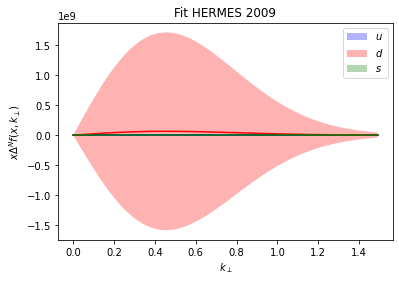

In [67]:
plotSivDistBandsNonNN(params09, sigmas09, .1, 2.4, .57, -2, np.array(list(range(150)))/100, 'Fit HERMES 2009', 'Plot1.pdf')

/home/nick/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5274: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/home/nick/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5275: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/home/nick/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5278: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice
/home/nick/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5280: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N+2:, 1] = dep2slice[::-1]
/home/nick/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/nick/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5274: ComplexWarning: Cast

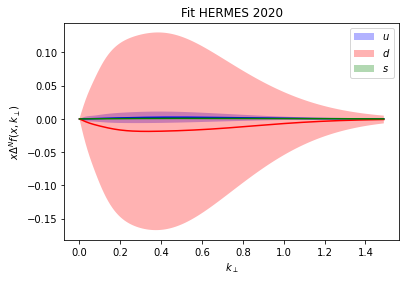

In [70]:
plotSivDistBandsNonNN(params20, sigmas20, .1, 2.4, .57, -2, np.array(list(range(150)))/100, 'Fit HERMES 2020', 'Plot3.pdf')

In [71]:
def plotSivDistBandsSeaNonNN(params, sigmas, x, QQ, kperp2avg, flavor, kperp, title, pdfname, numSigma=2):
    #datann = DataANN()
    #X, y, err = datann.makeData(df, [hadron], [dependence])
    
    paramstopass = [params['Nubar'], 0, 0, params['m1']]
    paramssigmas = [sigmas['Nubar'], 1, 1, sigmas['m1']]
    results = xsivdistFromReplicasNonNN(paramstopass, paramssigmas, x, QQ, kperp2avg, -2, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)

    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='b', alpha=0.3, label='$u_{sea}$')
    plt.plot(kperp, yhat, 'b')
    
    paramstopass = [params['Ndbar'], 0, 0, params['m1']]
    paramssigmas = [sigmas['Ndbar'], 0, 0, sigmas['m1']]
    results = xsivdistFromReplicasNonNN(paramstopass, paramssigmas, x, QQ, kperp2avg, -1, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='r', alpha=0.3, label='$d_{sea}$')
    plt.plot(kperp, yhat, 'r')
    
    paramstopass = [params['Nsbar'], 0, 0, params['m1']]
    paramssigmas = [sigmas['Nsbar'], 0, 0, sigmas['m1']]
    results = xsivdistFromReplicasNonNN(paramstopass, paramssigmas, x, QQ, kperp2avg, -3, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='g', alpha=0.3, label='$s_{sea}$')
    plt.plot(kperp, yhat, 'g')
    
    plt.legend()
    plt.title(title)
    plt.xlabel('$k_{\perp}$')
    plt.ylabel('$x\Delta^Nf(x, k_{\perp})$')
    plt.savefig(pdfname, format='pdf', bbox_inches='tight')

/home/nick/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5274: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/home/nick/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5275: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/home/nick/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5278: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice
/home/nick/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5280: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N+2:, 1] = dep2slice[::-1]
/home/nick/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/nick/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting 

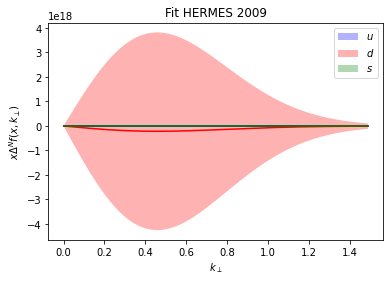

In [73]:
plotSivDistBandsNonNN(params09, sigmas09, .1, 2.4, .57, -2, np.array(list(range(150)))/100, 'Fit HERMES 2009', 'Plot5.pdf')

/home/nick/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5274: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/home/nick/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5275: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/home/nick/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5278: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice
/home/nick/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5280: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N+2:, 1] = dep2slice[::-1]
/home/nick/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/nick/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting 

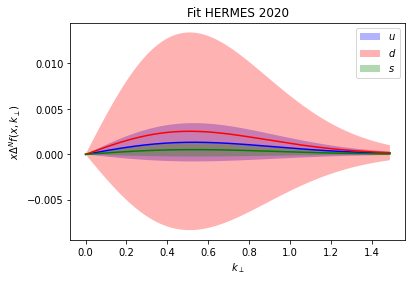

In [74]:
plotSivDistBandsNonNN(params20, sigmas20, .1, 2.4, .57, -2, np.array(list(range(150)))/100, 'Fit HERMES 2020', 'Plot7.pdf')

# Sivers Assymetry Plots

In [76]:
class DataANN(object):
    def __init__(self, pdfset='cteq61',
                 ff_PIp='NNFF10_PIp_nlo', ff_PIm='NNFF10_PIm_nlo', ff_PIsum='NNFF10_PIsum_nlo',
                 ff_KAp='NNFF10_KAp_nlo', ff_KAm='NNFF10_KAm_nlo'):
        '''
        Get data in proper format for neural network
        '''
        self.pdfData = lhapdf.mkPDF(pdfset)
        self.ffDataPIp = lhapdf.mkPDF(ff_PIp, 0)
        self.ffDataPIm = lhapdf.mkPDF(ff_PIm, 0)
        self.ffDataPIsum = lhapdf.mkPDF(ff_PIsum, 0)
        self.ffDataKAp = lhapdf.mkPDF(ff_KAp, 0)
        self.ffDataKAm = lhapdf.mkPDF(ff_KAm, 0)
        # needs to be extended to generalize for kaons
        self.eu = 2/3
        self.eubar = -2/3
        self.ed = -1/3
        self.edbar = 1/3
        self.es = -1/3
        self.esbar = 1/3
        
        self.ffDict = {0: self.ffDataPIp,
                       1: self.ffDataPIm,
                       2: self.ffDataPIsum,
                       3: self.ffDataKAp,
                       4: self.ffDataKAm}
    

    def pdf(self, flavor, x, QQ):
        return np.array([self.pdfData.xfxQ2(flavor, ax, qq) for ax, qq in zip(x, QQ)])
    
    
    def ff(self, func, flavor, z, QQ):
        return np.array([func.xfxQ2(flavor, az, qq) for az, qq in zip(z, QQ)])    
    

    def makeData(self, df, hadrons, dependencies):
        
        data = {'x': [],
             'z': [],
             'phT': [],
             'uexpr': [],
             'ubarexpr': [],
             'dexpr': [],
             'dbarexpr': [],
             'sexpr': [],
             'sbarexpr': []}
        
        y = []
        err = []
        
        df = df.loc[df['hadron'].isin(hadrons), :]
        df = df.loc[df['1D_dependence'].isin(dependencies), :]
        #X = np.array(df[['x', 'z', 'phT', 'Q2', 'hadron']])
        for i, had in enumerate(['pi+', 'pi-', 'pi0', 'k+', 'k-']):
            sliced = df.loc[df['hadron'] == had, :]
            y += list(sliced['Siv'])
            err += list(sliced['tot_err'])
            
            x = sliced['x']
            z = sliced['z']
            QQ = sliced['Q2']
            data['uexpr'] += list(self.eu**2 * self.pdf(2, x, QQ) * self.ff(self.ffDict[i], 2, z, QQ))
            data['ubarexpr'] += list(self.eubar**2 * self.pdf(-2, x, QQ) * self.ff(self.ffDict[i], -2, z, QQ))
            data['dexpr'] += list(self.ed**2 * self.pdf(1, x, QQ) * self.ff(self.ffDict[i], 1, z, QQ))
            data['dbarexpr'] += list(self.edbar**2 * self.pdf(-1, x, QQ) * self.ff(self.ffDict[i], -1, z, QQ))
            data['sexpr'] += list(self.es**2 * self.pdf(3, x, QQ) * self.ff(self.ffDict[i], 3, z, QQ))
            data['sbarexpr'] += list(self.esbar**2 * self.pdf(-3, x, QQ) * self.ff(self.ffDict[i], -3, z, QQ))

            data['x'] += list(x)
            data['z'] += list(z)
            data['phT'] += list(sliced['phT'])
        
        for key in data.keys():
            data[key] = np.array(data[key])
        
        return data, np.array(y), np.array(err)                      
       

In [80]:
def calc_yhat(model, X):
    return np.array([x[0] for x in model.predict(X)])

In [86]:
Xplt, yplt, errplt = datann.makeData(herm9, ['pi+'], ['x'])

In [98]:
herm9 = pd.read_csv('HERMES_p_2009.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')
herm20 = pd.read_csv('HERMES_p_2020.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')
comp9 = pd.read_csv('COMPASS_d_2009.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')
comp15 = pd.read_csv('COMPASS_p_2015.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')

In [115]:
def sivAsymPlot(df, hadron, ylim, title, savename, numSigma=2):
    datann = DataANN()
    Xplt, yplt, errplt = datann.makeData(df, [hadron], ['x'])
    results = []
    for i in range(10):
        t = tf.keras.models.load_model('Models/rep' + str(i) + '.h5', 
                                 custom_objects={'A0': A0, 'Quotient': Quotient})
        results.append(list(calc_yhat(t, Xplt)))
    results = np.array(results)
    
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(Xplt['x'], yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='r', alpha=0.3)
    plt.plot(Xplt['x'], yhat, 'r', label='Fit')
    
    #plt.plot(Xplt['x'], yhatplt, 'r',  label='yhat')
    plt.errorbar(Xplt['x'], yplt, yerr=errplt, fmt='bo', label='Data')
    plt.legend()
    plt.title(title)
    plt.ylim(ylim)
    plt.ylabel('Sivers Asymmetry')
    plt.xlabel('x')
    plt.savefig(savename)

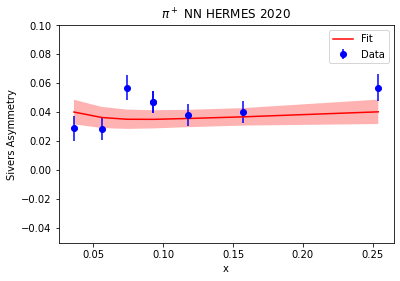

In [179]:
sivAsymPlot(herm20, 'pi+', (-.05, .1), '$\pi^+$ NN HERMES 2020', 'Plot12.pdf')

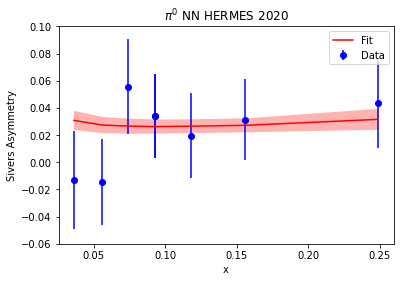

In [182]:
sivAsymPlot(herm20, 'pi0', (-.06, .1), '$\pi^0$ NN HERMES 2020', 'Plot16.pdf')

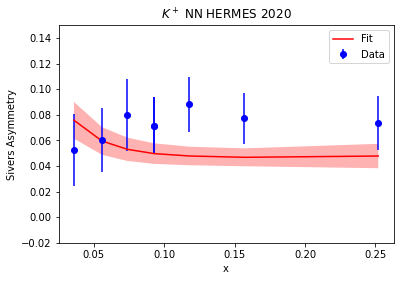

In [184]:
sivAsymPlot(herm20, 'k+', (-.02, .15), '$K^+$ NN HERMES 2020', 'Plot20.pdf')

In [124]:
test = NewFunctions.Hadron()

In [127]:
def dataslicercombined(df, hadrons, dependencies):
    '''
    returns X, y, err
    '''
    df = df.loc[df['hadron'].isin(hadrons), :]
    df = df.loc[df['1D_dependence'].isin(dependencies), :]
    X = np.array(df[['x', 'z', 'phT', 'Q2', 'hadron']])
    for i, had in enumerate(['pi+', 'pi-', 'pi0', 'k+', 'k-']):
        X[X[:, 4] == had, 4] = i
    X = X.astype('float')
    return X, np.array(df['Siv']), np.array(df['tot_err'])

In [131]:
Xplt

array([[0.086, 0.234, 0.346, 2.423, 0.   ],
       [0.094, 0.303, 0.377, 2.428, 0.   ],
       [0.097, 0.373, 0.403, 2.425, 0.   ],
       [0.099, 0.447, 0.429, 2.418, 0.   ],
       [0.1  , 0.523, 0.453, 2.411, 0.   ],
       [0.101, 0.593, 0.465, 2.4  , 0.   ],
       [0.103, 0.663, 0.465, 2.385, 0.   ]])

In [134]:
2.**2

4.0

In [148]:
def orderParams(params):
    return [params['Nu'], params['Nd'], params['Ns'], params['Nubar'], params['Ndbar'], params['Nsbar'], params['au'], params['ad'], params['as0'], params['bu'], params['bd'], params['bs'], params['m1']]

In [139]:

yhatplt = test.sivers(Xplt, *params09.values())

/home/nick/Documents/Sivers/NewFunctions.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  res[idxs] = a0*(numerator/denominator)


In [161]:
def sivAsymPlotNonNN(df, params, sigmas, hadron, ylim, title, savename, numSigma=2):
    datann = DataANN()
    had = NewFunctions.Hadron()
    Xplt, yplt, errplt = datann.makeData(df, [hadron], ['x'])
    Xpltwflag, _, _ = dataslicercombined(df, [hadron], ['x'])
    results = []
    for i in range(100):
        run_params = [np.random.normal(p, s) for p, s in zip(params, sigmas)]
        results.append(had.sivers(Xpltwflag, *run_params))
    results = np.array(results)
    
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(Xplt['x'], yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='r', alpha=0.3)
    plt.plot(Xplt['x'], yhat, 'r', label='Fit')
    
    #plt.plot(Xplt['x'], yhatplt, 'r',  label='yhat')
    plt.errorbar(Xplt['x'], yplt, yerr=errplt, fmt='bo', label='Data')
    plt.legend()
    plt.title(title)
    plt.ylim(ylim)
    plt.ylabel('Sivers Asymmetry')
    plt.xlabel('x')
    plt.savefig(savename)

/home/nick/Documents/Sivers/NewFunctions.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  res[idxs] = a0*(numerator/denominator)


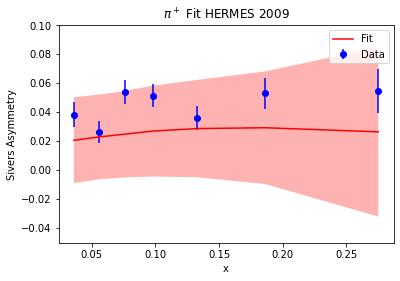

In [164]:
sivAsymPlotNonNN(herm9, orderParams(params09), orderParams(sigmas09), 'pi+', (-.05, .1),
                 '$\pi^+$ Fit HERMES 2009', 'Plot9.pdf')

/home/nick/Documents/Sivers/NewFunctions.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  res[idxs] = a0*(numerator/denominator)


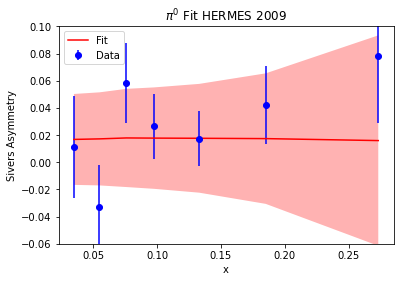

In [181]:
sivAsymPlotNonNN(herm9, orderParams(params09), orderParams(sigmas09), 'pi0', (-.06, .1),
                 '$\pi^0$ Fit HERMES 2009', 'Plot13.pdf')

/home/nick/Documents/Sivers/NewFunctions.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  res[idxs] = a0*(numerator/denominator)


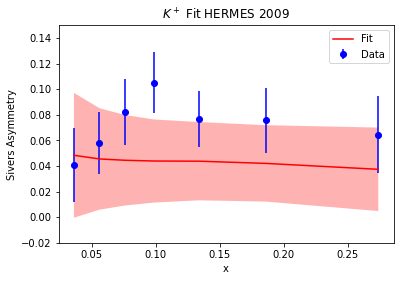

In [168]:
sivAsymPlotNonNN(herm9, orderParams(params09), orderParams(sigmas09), 'k+', (-.02, .15),
                 '$K^+$ Fit HERMES 2009', 'Plot17.pdf')

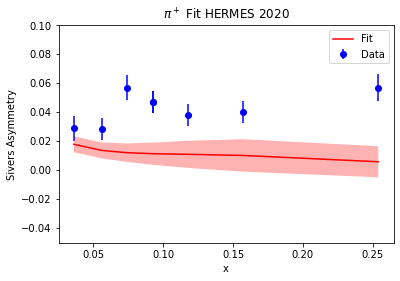

In [180]:
sivAsymPlotNonNN(herm20, orderParams(params20), orderParams(sigmas20), 'pi+', (-.05, .1),
                 '$\pi^+$ Fit HERMES 2020', 'Plot11.pdf')

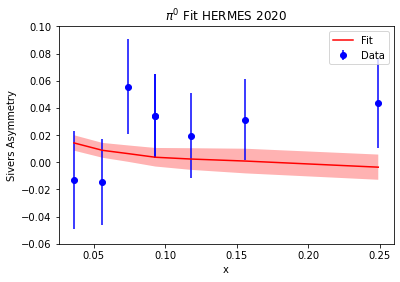

In [174]:
sivAsymPlotNonNN(herm20, orderParams(params20), orderParams(sigmas20), 'pi0', (-.06, .1),
                 '$\pi^0$ Fit HERMES 2020', 'Plot15.pdf')

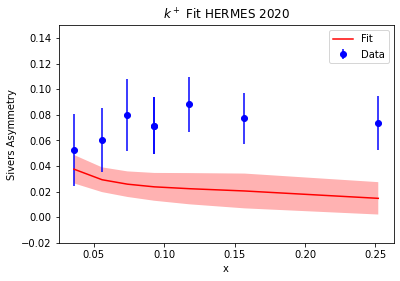

In [183]:
sivAsymPlotNonNN(herm20, orderParams(params20), orderParams(sigmas20), 'k+', (-.02, .15),
                 '$k^+$ Fit HERMES 2020', 'Plot19.pdf')